In [4]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0" 
import torch
torch.cuda.device_count()

1

In [5]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from glob import glob
# import wandb

import monai
from monai.losses import DiceCELoss, DiceFocalLoss, FocalLoss
from monai.inferers import sliding_window_inference
from monai import transforms

from monai.transforms import (
    AsDiscrete,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
    MapTransform,
    ScaleIntensityd,
    #AddChanneld,
    SpatialPadd,
    CenterSpatialCropd,
    EnsureChannelFirstd,
    ConcatItemsd,
    AdjustContrastd, 
    Rand3DElasticd,
    HistogramNormalized,
    NormalizeIntensityd,
    Invertd,
    SaveImage,

)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.networks.nets import SwinUNETR, UNETR, SegResNet

from monai.data import (
    DataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
)
from monai import data


from monai.utils import first, set_determinism
from sklearn.model_selection import train_test_split
import json


import torch

In [3]:
set_determinism(seed=1024)


In [ ]:
# import json
# import os
# import random

# centers = ['CHUM', 'CHUP', 'CHUS', 'CHUV', 'HGJ', 'HMR', 'MDA']
# base_dir = '/home/nada.saadi/MIS-FM/hecktor2022_cropped'
# num_folds = 4

# # Function to generate file paths for a patient
# def generate_paths(center, patient_id):
#     return {
#         'id': os.path.join(base_dir, center, patient_id),
#         'ct': os.path.join(base_dir, center, patient_id, f"{patient_id}_ct.nii.gz"),
#         'pt': os.path.join(base_dir, center, patient_id, f"{patient_id}_pt.nii.gz"),
#         'seg': os.path.join(base_dir, center, patient_id, f"{patient_id}_gt.nii.gz")
#     }

# # Gather all data entries
# all_data = []
# for center in centers:
#     # Replace this with actual method to list patient IDs in each center
#     patient_ids = os.listdir(os.path.join(base_dir, center))
#     for patient_id in patient_ids:
#         all_data.append(generate_paths(center, patient_id))

# # Randomly assign data to folds
# for entry in all_data:
#     entry['fold'] = random.randint(1, num_folds)

# # Wrap data in a parent dictionary under the "training" key
# data_json = {"training": all_data}

# # Save to JSON file
# json_file_path = "/home/nada.saadi/MIS-FM/hecktor2022_cropped/train_json_new.json"
# with open(json_file_path, "w") as f:
#     json.dump(data_json, f, indent=4)

# print(f"JSON file created at {json_file_path}")


In [6]:
import os
import json
import random

def generate_paths(patient_id):
    base_dir = '/home/nada.saadi/MIS-FM/hecktor2022_cropped/data'
    return {
        'id': os.path.join(base_dir, patient_id),
        'ct': os.path.join(base_dir, patient_id, f"{patient_id}_ct.nii.gz"),
        'seg': os.path.join(base_dir, patient_id, f"{patient_id}_gt.nii.gz")
    }

# Assign each data entry to a random fold
all_data = []
num_folds = 5

for file_dir in sorted(glob('data/*')):
    patient_id = file_dir.split('/')[-1]
    entry = generate_paths(patient_id)
    entry['fold'] = random.randint(1, num_folds) - 1
    all_data.append(entry)

# Compile data into a JSON structure
data_json = {"training": all_data}

# Remove the 'pt' key from each entry
for entry in data_json["training"]:
    if "pt" in entry:
        del entry["pt"]

# Save to JSON file
json_file_path = "/home/nada.saadi/MIS-FM/hecktor2022_cropped/ct_train_new.json"
with open(json_file_path, 'w') as f:
    json.dump(data_json, f, indent=4)

print(f"JSON file created at {json_file_path}")



JSON file created at /home/nada.saadi/MIS-FM/hecktor2022_cropped/ct_train_new.json


In [ ]:
# import json
# import os
# import random

# # Assuming the 'patient_ids' list contains all the patient IDs from different centers
# random.shuffle(patient_ids)

# # Split into training and validation sets (80% training, 20% validation)
# # Total files = 419 (training) + 105 (validation)
# num_training = 419
# num_validation = 105
# train_patient_ids = patient_ids[:num_training]
# val_patient_ids = patient_ids[num_training:num_training + num_validation]

# # Generate dictionaries for training and validation
# train_dicts = []
# val_dicts = []

# for pid in train_patient_ids:
#     train_dicts.append({
#         'id': f"/home/nada.saadi/MIS-FM/hecktor2022_cropped/{pid}",
#         'fold': random.randint(0, 3),  # Random fold assignment
#         'ct': f"/home/nada.saadi/MIS-FM/hecktor2022_cropped/{pid}/{pid}_ct.nii.gz",
#         'pt': f"/home/nada.saadi/MIS-FM/hecktor2022_cropped/{pid}/{pid}_pt.nii.gz",
#         'seg': f"/home/nada.saadi/MIS-FM/hecktor2022_cropped/{pid}/{pid}_gt.nii.gz"
#     })

# for pid in val_patient_ids:
#     val_dicts.append({
#         'id': f"/home/nada.saadi/MIS-FM/hecktor2022_cropped/{pid}",
#         'fold': random.randint(0, 3),  # Random fold assignment
#         'ct': f"/home/nada.saadi/MIS-FM/hecktor2022_cropped/{pid}/{pid}_ct.nii.gz",
#         'pt': f"/home/nada.saadi/MIS-FM/hecktor2022_cropped/{pid}/{pid}_pt.nii.gz",
#         'seg': f"/home/nada.saadi/MIS-FM/hecktor2022_cropped/{pid}/{pid}_gt.nii.gz"
#     })

# # Creating JSON data structure
# json_data = {
#     "training": train_dicts,
#     "validation": val_dicts
# }

# # Save as JSON file
# json_file_path = "/home/nada.saadi/MIS-FM/hecktor2022_cropped/train_val_json_new.json"
# with open(json_file_path, 'w') as f:
#     json.dump(json_data, f, indent=4)

# # Outputting the path of the JSON file
# json_file_path



In [4]:
data_dir = '/home/nada.saadi/MIS-FM/hecktor2022_cropped'
json_dir = '/home/nada.saadi/MIS-FM/hecktor2022_cropped/ct_train_new.json'

In [7]:
def datafold_read(datalist, basedir, fold=0, key="training"):
    with open(datalist) as f:
        json_data = json.load(f)

    json_data = json_data[key]

    for d in json_data:
        for k in d:
            if isinstance(d[k], list):
                d[k] = [os.path.join(basedir, iv) for iv in d[k]]
            elif isinstance(d[k], str):
                d[k] = os.path.join(basedir, d[k]) if len(d[k]) > 0 else d[k]

    tr = []
    val = []
    for d in json_data:
        if "fold" in d and d["fold"] == fold:
            val.append(d)
        else:
            tr.append(d)

    return tr, val

In [6]:
train_files, validation_files = datafold_read(datalist=json_dir, basedir=data_dir, fold=0)
len(train_files), len(validation_files)

(393, 127)

In [7]:
print(train_files[1])


{'id': '/home/nada.saadi/MIS-FM/hecktor2022_cropped/data/CHUM-006', 'ct': '/home/nada.saadi/MIS-FM/hecktor2022_cropped/data/CHUM-006/CHUM-006_ct.nii.gz', 'seg': '/home/nada.saadi/MIS-FM/hecktor2022_cropped/data/CHUM-006/CHUM-006_gt.nii.gz', 'fold': 3}


/home/nada.saadi/miniconda3/envs/clam/lib/python3.8/site-packages/monai/transforms/spatial/array.py:635: UserWarning: axcodes ('RAS') length is smaller than number of input spatial dimensions D=2.
Orientation: spatial shape = (200, 310), channels = 200,please make sure the input is in the channel-first format.
  warnings.warn(


torch.Size([200, 200, 310])


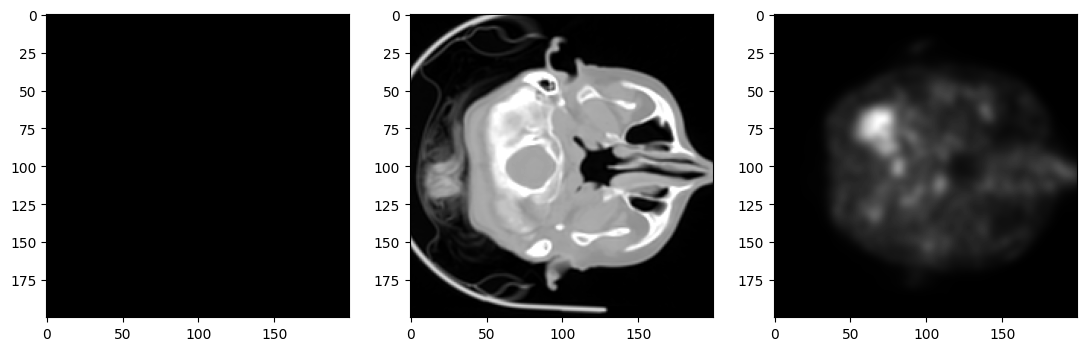

In [8]:
from skimage import measure

slice_num = 133
gt = monai.transforms.LoadImage(ensure_channel_first=True)('data/CHUS-081/CHUS-081_gt.nii.gz')
plt.figure("image", (18, 10))
gt = monai.transforms.Orientation(axcodes='RAS')(gt[0])
plt.subplot(2, 4, 1)
plt.imshow(gt[:,:,slice_num], cmap='gray')
print(gt.shape)

#contours = measure.find_contours(gt[:,slice_num,:], 0.5)[0]
#plt.plot(contours[:, 1], contours[:, 0], linewidth=0.8, c='red',  alpha = 0.8)

ct = monai.transforms.LoadImage(ensure_channel_first=True)('data/CHUV-002/CHUV-002_ct.nii.gz')
ct = monai.transforms.Orientation(axcodes='RAS')(ct[0])
ct = torch.clip(ct, min=-1000, max=600)
plt.subplot(2, 4, 2)
plt.imshow(ct[:,:,slice_num], cmap='gray')
#plt.plot(contours[:, 1], contours[:, 0], linewidth=0.8, c='red',  alpha = 0.8)

pt = monai.transforms.LoadImage(ensure_channel_first=True)('data/CHUV-002/CHUV-002_pt.nii.gz')
pt = monai.transforms.Orientation(axcodes='RAS')(pt[0])
plt.subplot(2, 4, 3)
plt.imshow(pt[:,:,slice_num], cmap='gray')
#plt.plot(contours[:, 1], contours[:, 0], linewidth=0.8, c='red',  alpha = 0.8)

In [16]:
class ClipCT(MapTransform):
    """
    Convert labels to multi channels based on hecktor classes:
    label 1 is the tumor
    label 2 is the lymph node

    """

    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            if key == "ct":
                d[key] = torch.clip(d[key], min=-200, max=200)
            # elif key == "pt":
            #     d[key] = torch.clip(d[key], d[key].min(), 5)
        return d

class MulPTFM(MapTransform):
    """
    Mult PT and FM 

    """

    def __call__(self, data):
        d = dict(data)

        fm = d["ct"] > 0
        d["pt"] = d["pt"] * fm
        return d

class SelectClass(MapTransform):
    """
    Select the class for which you want to fine tune the model 

    """
    # def __init__(self, keys, cls=1):
    #     super(self).__init__(keys)
    #     self.cls = cls

    def __call__(self, data):
        d = dict(data)
        d["seg"][d["seg"] == 1] = 0
        # d["seg"][d["seg"] == 2] = 1
        
        return d

In [62]:
num_samples = 4

train_transforms = Compose(
    [
        LoadImaged(keys=["ct", "seg"], ensure_channel_first = True),
        SpatialPadd(keys=["ct",  "seg"], spatial_size=(200, 200, 310), method='end'),
        Orientationd(keys=["ct",  "seg"], axcodes="PLS"),
        #NormalizeIntensityd(keys=["pt"]),
        ClipCT(keys=["ct"]),
        ScaleIntensityd(keys=["ct"], minv=0, maxv=1),
        #MulPTFM(keys=["ct","pt"]),
        #ConcatItemsd(keys=["pt", "ct"], name="ctpt"),
        #NormalizeIntensityd(keys=["ctpt"], channel_wise=True),
        RandCropByPosNegLabeld(
            keys=["ct", "seg"],
            label_key="seg",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=num_samples,
            image_key="ct",
            image_threshold=0,
        ),
        RandFlipd(
            keys=["ct", "seg"],
            spatial_axis=[0],
            prob=0.20,
        ),
        RandFlipd(
            keys=["ct", "seg"],
            spatial_axis=[1],
            prob=0.20,
        ),
        RandFlipd(
            keys=["ct", "seg"],
            spatial_axis=[2],
            prob=0.20,
        ),
        RandRotate90d(
            keys=["ct", "seg"],
            prob=0.20,
            max_k=3,
        ),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["ct", "seg"], ensure_channel_first = True),
        SpatialPadd(keys=["ct", "seg"], spatial_size=(200, 200, 310), method='end'),
        Orientationd(keys=["ct",  "seg"], axcodes="PLS"),
        #NormalizeIntensityd(keys=["pt"]),
        ClipCT(keys=["ct"]),
        ScaleIntensityd(keys=["ct"], minv=0, maxv=1),
        #MulPTFM(keys=["ct","pt"]),
        #ConcatItemsd(keys=["pt", "ct"], name="ctpt"),
    ]
)

In [18]:
train_ds = monai.data.Dataset(data=train_files, transform=train_transforms)

train_loader = DataLoader(
    train_ds,
    batch_size=2,
    shuffle=True,
    num_workers=8,
    pin_memory=torch.cuda.is_available(),
    )

val_ds = monai.data.Dataset(data=validation_files, transform=val_transforms)

val_loader = DataLoader(
    val_ds, 
    batch_size=2, 
    num_workers=8, 
    shuffle= False)

In [11]:
a = next(iter(train_loader))

In [12]:
a['ct'].shape

torch.Size([8, 1, 96, 96, 96])

In [19]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model = SegResNet(in_channels=2, 
#                   out_channels=3, 
#                   init_filters=16).to(device)

# model = UNETR(
#     in_channels=2,
#     out_channels=3,
#     img_size=(96, 96, 96),
#     feature_size=16,
#     hidden_size=768,
#     mlp_dim=3072,
#     num_heads=12,
#     pos_embed="perceptron",
#     norm_name="instance",
#     res_block=True,
#     dropout_rate=0.0,
# ).to(device)

model = SwinUNETR(img_size= (96, 96, 96),
                  in_channels=1, #changed from 2 to 1
                  out_channels=3,
                  depths = (2, 2, 2, 2),
                  num_heads = (3, 6, 12, 24),
                  feature_size = 24,
                  norm_name = "instance",
                  drop_rate = 0.0,
                attn_drop_rate = 0.0,
                dropout_path_rate = 0.0,
                normalize = True,
                use_checkpoint = False,
                spatial_dims = 3,
                downsample="merging").to(device)

In [20]:
torch.backends.cudnn.benchmark = True
def poly_lr(epoch, max_epochs, initial_lr, exponent=0.9):
    return initial_lr * (1 - epoch / max_epochs)**exponent

loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

In [15]:
model_dir = '/home/nada.saadi/MIS-FM/hecktor2022_cropped/ct_files'

def validation(epoch_iterator_val):
    model.eval()
    with torch.no_grad():
        for step, batch in enumerate(epoch_iterator_val):
            val_inputs, val_labels = (batch["ct"].cuda(), batch["seg"].cuda())
            val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [
                post_label(val_label_tensor) for val_label_tensor in val_labels_list
            ]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [
                post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list
            ]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            dice_metric_batch(y_pred=val_output_convert, y=val_labels_convert)
            epoch_iterator_val.set_description(
                "Validate (%d / %d Steps)" % (global_step, 10.0)
            )
        mean_dice_val = dice_metric.aggregate().item()
        metric_batch_val = dice_metric_batch.aggregate()

        metric_tumor = metric_batch_val[0].item()
        metric_lymph = metric_batch_val[1].item()

        dice_metric.reset()
        dice_metric_batch.reset()
    return mean_dice_val, metric_tumor, metric_lymph


def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(
        train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True
    )
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["ct"].cuda(), batch["seg"].cuda())
        logit_map = model(x)
        loss = loss_function(logit_map, y)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description(
            "Training (%d / %d Steps) (loss=%2.5f)"
            % (global_step, max_iterations, loss)
        )
        if (
            global_step % eval_num == 0 and global_step != 0
        ) or global_step == max_iterations:
            epoch_iterator_val = tqdm(
                val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True
            )
            dice_val, metric_tumor, metric_lymph = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            metric_values_tumor.append(metric_tumor)
            metric_values_lymph.append(metric_lymph)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(
                    model.state_dict(), os.path.join(model_dir, "best_metric_unetr.pth")
                )
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {} Current Avg. tumor Dice: {} Current Avg. lymph Dice: {}".format(
                        dice_val_best, dice_val, metric_tumor, metric_lymph
                    )
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {} Current Avg. tumor Dice: {} Current Avg. lymph Dice: {}".format(
                        dice_val_best, dice_val,  metric_tumor, metric_lymph
                    )
                )
        global_step += 1
    return global_step, dice_val_best, global_step_best


max_iterations = 18000
eval_num = 100

post_label = AsDiscrete(to_onehot=3)
post_pred = AsDiscrete(argmax=True, to_onehot=3)

dice_metric = DiceMetric(include_background=False, reduction="mean", get_not_nans=False)
dice_metric_batch = DiceMetric(include_background=False, reduction="mean_batch")

epoch = 0
max_num_epochs = 530

global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
metric_values_tumor = []
metric_values_lymph = []
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(
        global_step, train_loader, dice_val_best, global_step_best
    )
    # wandb.log({'learning_rate': optimizer.param_groups[0]['lr']})
    # wandb.log({'Best Dice': dice_val_best})
    epoch += 1
    #optimizer.param_groups[0]['lr'] = poly_lr(epoch, max_num_epochs, 0.005676 , 0.9)
# model.load_state_dict(torch.load(os.path.join(model_dir, "best_metric_luck_UNETr_prompt.pth")))

Training (X / X Steps) (loss=X.X):   0%|          | 0/203 [00:00<?, ?it/s]

Training (100 / 18000 Steps) (loss=1.08060):  50%|████▉     | 101/203 [05:06<1:37:35, 57.40s/it]

Model Was Saved ! Current Best Avg. Dice: 2.82686028185708e-06 Current Avg. Dice: 2.82686028185708e-06 Current Avg. tumor Dice: 5.7033148550544865e-06 Current Avg. lymph Dice: 0.0


Training (200 / 18000 Steps) (loss=0.98035):  99%|█████████▉| 201/203 [09:56<01:53, 56.72s/it]

Model Was Saved ! Current Best Avg. Dice: 0.021768948063254356 Current Avg. Dice: 0.021768948063254356 Current Avg. tumor Dice: 0.03732939064502716 Current Avg. lymph Dice: 4.302031811675988e-05


Training (300 / 18000 Steps) (loss=0.90452):  48%|████▊     | 98/203 [04:50<1:39:15, 56.72s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.021768948063254356 Current Avg. Dice: 1.943684219440911e-05 Current Avg. tumor Dice: 3.804990410571918e-05 Current Avg. lymph Dice: 1.2646141840377823e-06


Training (400 / 18000 Steps) (loss=0.86764):  98%|█████████▊| 198/203 [09:40<04:43, 56.75s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.021768948063254356 Current Avg. Dice: 0.018942201510071754 Current Avg. tumor Dice: 0.030637109652161598 Current Avg. lymph Dice: 1.0493297395441914e-06


Training (500 / 18000 Steps) (loss=0.85084):  47%|████▋     | 95/203 [04:47<1:42:13, 56.79s/it]

Model Was Saved ! Current Best Avg. Dice: 0.06346414238214493 Current Avg. Dice: 0.06346414238214493 Current Avg. tumor Dice: 0.11545789986848831 Current Avg. lymph Dice: 4.509988229983719e-06


Training (600 / 18000 Steps) (loss=0.78990):  96%|█████████▌| 195/203 [09:38<07:34, 56.76s/it]

Model Was Saved ! Current Best Avg. Dice: 0.15359145402908325 Current Avg. Dice: 0.15359145402908325 Current Avg. tumor Dice: 0.14984208345413208 Current Avg. lymph Dice: 0.15585742890834808


Training (700 / 18000 Steps) (loss=0.73474):  45%|████▌     | 92/203 [04:44<1:45:01, 56.77s/it]

Model Was Saved ! Current Best Avg. Dice: 0.23244871199131012 Current Avg. Dice: 0.23244871199131012 Current Avg. tumor Dice: 0.22007399797439575 Current Avg. lymph Dice: 0.25112879276275635


Training (800 / 18000 Steps) (loss=0.72793):  95%|█████████▍| 192/203 [09:35<10:25, 56.91s/it]

Model Was Saved ! Current Best Avg. Dice: 0.2745150923728943 Current Avg. Dice: 0.2745150923728943 Current Avg. tumor Dice: 0.28673604130744934 Current Avg. lymph Dice: 0.2655639946460724


Training (900 / 18000 Steps) (loss=0.72390):  44%|████▍     | 89/203 [04:41<1:48:04, 56.88s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.2745150923728943 Current Avg. Dice: 0.26367267966270447 Current Avg. tumor Dice: 0.24036625027656555 Current Avg. lymph Dice: 0.29292964935302734


Training (1000 / 18000 Steps) (loss=0.64066):  93%|█████████▎| 189/203 [09:32<13:14, 56.78s/it]

Model Was Saved ! Current Best Avg. Dice: 0.29843902587890625 Current Avg. Dice: 0.29843902587890625 Current Avg. tumor Dice: 0.3215740919113159 Current Avg. lymph Dice: 0.2754807770252228


Training (1100 / 18000 Steps) (loss=0.70096):  42%|████▏     | 86/203 [04:38<1:50:42, 56.78s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.29843902587890625 Current Avg. Dice: 0.27443426847457886 Current Avg. tumor Dice: 0.2586337924003601 Current Avg. lymph Dice: 0.2993755638599396


Training (1200 / 18000 Steps) (loss=0.64727):  92%|█████████▏| 186/203 [09:29<16:06, 56.84s/it]

Model Was Saved ! Current Best Avg. Dice: 0.367705762386322 Current Avg. Dice: 0.367705762386322 Current Avg. tumor Dice: 0.37489819526672363 Current Avg. lymph Dice: 0.3662426471710205


Training (1300 / 18000 Steps) (loss=0.59356):  41%|████      | 83/203 [04:34<1:53:14, 56.62s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.367705762386322 Current Avg. Dice: 0.32321226596832275 Current Avg. tumor Dice: 0.3016873300075531 Current Avg. lymph Dice: 0.35570958256721497


Training (1400 / 18000 Steps) (loss=0.66614):  90%|█████████ | 183/203 [09:23<18:50, 56.52s/it]

Model Was Saved ! Current Best Avg. Dice: 0.37273067235946655 Current Avg. Dice: 0.37273067235946655 Current Avg. tumor Dice: 0.38113564252853394 Current Avg. lymph Dice: 0.37078747153282166


Training (1500 / 18000 Steps) (loss=0.55881):  39%|███▉      | 80/203 [04:32<1:56:35, 56.87s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.37273067235946655 Current Avg. Dice: 0.3638392984867096 Current Avg. tumor Dice: 0.392907053232193 Current Avg. lymph Dice: 0.3381885588169098


Training (1600 / 18000 Steps) (loss=0.64744):  89%|████████▊ | 180/203 [09:23<21:50, 56.98s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.37273067235946655 Current Avg. Dice: 0.3280560374259949 Current Avg. tumor Dice: 0.34041139483451843 Current Avg. lymph Dice: 0.3154340386390686


Training (1700 / 18000 Steps) (loss=0.54100):  38%|███▊      | 77/203 [04:28<1:59:00, 56.67s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.37273067235946655 Current Avg. Dice: 0.347513347864151 Current Avg. tumor Dice: 0.3702870011329651 Current Avg. lymph Dice: 0.3275879919528961


Training (1800 / 18000 Steps) (loss=0.53913):  87%|████████▋ | 177/203 [09:18<24:33, 56.68s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.37273067235946655 Current Avg. Dice: 0.3703300952911377 Current Avg. tumor Dice: 0.35455822944641113 Current Avg. lymph Dice: 0.39692217111587524


Training (1900 / 18000 Steps) (loss=0.63992):  36%|███▋      | 74/203 [04:25<2:02:20, 56.90s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.37273067235946655 Current Avg. Dice: 0.328387588262558 Current Avg. tumor Dice: 0.3537452220916748 Current Avg. lymph Dice: 0.3079034388065338


Training (2000 / 18000 Steps) (loss=0.60062):  86%|████████▌ | 174/203 [09:17<27:34, 57.06s/it]

Model Was Saved ! Current Best Avg. Dice: 0.39238858222961426 Current Avg. Dice: 0.39238858222961426 Current Avg. tumor Dice: 0.39690449833869934 Current Avg. lymph Dice: 0.39372190833091736


Training (2100 / 18000 Steps) (loss=0.49342):  35%|███▍      | 71/203 [04:22<2:04:59, 56.82s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.39238858222961426 Current Avg. Dice: 0.386836439371109 Current Avg. tumor Dice: 0.37264594435691833 Current Avg. lymph Dice: 0.40972673892974854


Training (2200 / 18000 Steps) (loss=0.56121):  84%|████████▍ | 171/203 [09:14<30:27, 57.10s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.39238858222961426 Current Avg. Dice: 0.387389212846756 Current Avg. tumor Dice: 0.36840352416038513 Current Avg. lymph Dice: 0.41721001267433167


Training (2300 / 18000 Steps) (loss=0.59634):  33%|███▎      | 68/203 [04:21<2:08:55, 57.30s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.39238858222961426 Current Avg. Dice: 0.39075005054473877 Current Avg. tumor Dice: 0.403323233127594 Current Avg. lymph Dice: 0.38203293085098267


Training (2400 / 18000 Steps) (loss=0.62674):  83%|████████▎ | 168/203 [09:13<33:21, 57.18s/it]

Model Was Saved ! Current Best Avg. Dice: 0.40550562739372253 Current Avg. Dice: 0.40550562739372253 Current Avg. tumor Dice: 0.39575549960136414 Current Avg. lymph Dice: 0.42448562383651733


Training (2500 / 18000 Steps) (loss=0.62768):  32%|███▏      | 65/203 [04:16<2:11:02, 56.97s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.40550562739372253 Current Avg. Dice: 0.37781059741973877 Current Avg. tumor Dice: 0.36888858675956726 Current Avg. lymph Dice: 0.3912799656391144


Training (2600 / 18000 Steps) (loss=0.61883):  81%|████████▏ | 165/203 [09:07<35:57, 56.79s/it]

Model Was Saved ! Current Best Avg. Dice: 0.40671414136886597 Current Avg. Dice: 0.40671414136886597 Current Avg. tumor Dice: 0.40257322788238525 Current Avg. lymph Dice: 0.42204549908638


Training (2700 / 18000 Steps) (loss=0.58005):  31%|███       | 62/203 [04:13<2:13:40, 56.88s/it]

Model Was Saved ! Current Best Avg. Dice: 0.4083735942840576 Current Avg. Dice: 0.4083735942840576 Current Avg. tumor Dice: 0.4065881073474884 Current Avg. lymph Dice: 0.4169269800186157


Training (2800 / 18000 Steps) (loss=0.42494):  80%|███████▉  | 162/203 [09:05<39:04, 57.18s/it]

Model Was Saved ! Current Best Avg. Dice: 0.4217810034751892 Current Avg. Dice: 0.4217810034751892 Current Avg. tumor Dice: 0.4299948215484619 Current Avg. lymph Dice: 0.42163172364234924


Training (2900 / 18000 Steps) (loss=0.55604):  29%|██▉       | 59/203 [04:10<2:16:59, 57.08s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.4217810034751892 Current Avg. Dice: 0.4113461971282959 Current Avg. tumor Dice: 0.3921923041343689 Current Avg. lymph Dice: 0.4392131567001343


Training (3000 / 18000 Steps) (loss=0.50748):  78%|███████▊  | 159/203 [09:01<41:46, 56.96s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.4217810034751892 Current Avg. Dice: 0.417659729719162 Current Avg. tumor Dice: 0.4035531282424927 Current Avg. lymph Dice: 0.4444954991340637


Training (3100 / 18000 Steps) (loss=0.66464):  28%|██▊       | 56/203 [04:07<2:19:02, 56.75s/it]

Model Was Saved ! Current Best Avg. Dice: 0.4244177043437958 Current Avg. Dice: 0.4244177043437958 Current Avg. tumor Dice: 0.420992374420166 Current Avg. lymph Dice: 0.4358026385307312


Training (3200 / 18000 Steps) (loss=0.56597):  77%|███████▋  | 156/203 [08:58<44:33, 56.88s/it]

Model Was Saved ! Current Best Avg. Dice: 0.4425555467605591 Current Avg. Dice: 0.4425555467605591 Current Avg. tumor Dice: 0.4490477442741394 Current Avg. lymph Dice: 0.44348976016044617


Training (3300 / 18000 Steps) (loss=0.43022):  26%|██▌       | 53/203 [04:03<2:21:48, 56.72s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.4425555467605591 Current Avg. Dice: 0.4361286461353302 Current Avg. tumor Dice: 0.4127891957759857 Current Avg. lymph Dice: 0.4731530249118805


Training (3400 / 18000 Steps) (loss=0.47338):  75%|███████▌  | 153/203 [08:54<47:18, 56.76s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.4425555467605591 Current Avg. Dice: 0.40365681052207947 Current Avg. tumor Dice: 0.406644731760025 Current Avg. lymph Dice: 0.40622442960739136


Training (3500 / 18000 Steps) (loss=0.48424):  25%|██▍       | 50/203 [04:01<2:25:35, 57.09s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.4425555467605591 Current Avg. Dice: 0.4260652959346771 Current Avg. tumor Dice: 0.42787885665893555 Current Avg. lymph Dice: 0.4326935410499573


Training (3600 / 18000 Steps) (loss=0.42405):  74%|███████▍  | 150/203 [08:52<50:18, 56.95s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.4425555467605591 Current Avg. Dice: 0.4267987310886383 Current Avg. tumor Dice: 0.40332430601119995 Current Avg. lymph Dice: 0.46168053150177


Training (3700 / 18000 Steps) (loss=0.59284):  23%|██▎       | 47/203 [03:58<2:28:41, 57.19s/it]

Model Was Saved ! Current Best Avg. Dice: 0.45440608263015747 Current Avg. Dice: 0.45440608263015747 Current Avg. tumor Dice: 0.45357856154441833 Current Avg. lymph Dice: 0.4645523726940155


Training (3800 / 18000 Steps) (loss=0.52725):  72%|███████▏  | 147/203 [08:50<53:23, 57.20s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.45440608263015747 Current Avg. Dice: 0.4069187641143799 Current Avg. tumor Dice: 0.3735707700252533 Current Avg. lymph Dice: 0.4531399607658386


Training (3900 / 18000 Steps) (loss=0.49649):  22%|██▏       | 44/203 [03:54<2:30:43, 56.88s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.45440608263015747 Current Avg. Dice: 0.4134407639503479 Current Avg. tumor Dice: 0.41541969776153564 Current Avg. lymph Dice: 0.4238360822200775


Training (4000 / 18000 Steps) (loss=0.63698):  71%|███████   | 144/203 [08:46<56:06, 57.05s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.45440608263015747 Current Avg. Dice: 0.4187542498111725 Current Avg. tumor Dice: 0.38390272855758667 Current Avg. lymph Dice: 0.46574482321739197


Training (4100 / 18000 Steps) (loss=0.61190):  20%|██        | 41/203 [03:52<2:34:04, 57.06s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.45440608263015747 Current Avg. Dice: 0.4249074161052704 Current Avg. tumor Dice: 0.4063853621482849 Current Avg. lymph Dice: 0.45236220955848694


Training (4200 / 18000 Steps) (loss=0.57658):  69%|██████▉   | 141/203 [08:44<59:03, 57.16s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.45440608263015747 Current Avg. Dice: 0.434040904045105 Current Avg. tumor Dice: 0.41683557629585266 Current Avg. lymph Dice: 0.46352437138557434


Training (4300 / 18000 Steps) (loss=0.55851):  19%|█▊        | 38/203 [03:49<2:36:55, 57.06s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.45440608263015747 Current Avg. Dice: 0.43827858567237854 Current Avg. tumor Dice: 0.4128049314022064 Current Avg. lymph Dice: 0.4783988893032074


Training (4400 / 18000 Steps) (loss=0.53302):  68%|██████▊   | 138/203 [08:40<1:01:41, 56.95s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.45440608263015747 Current Avg. Dice: 0.44955629110336304 Current Avg. tumor Dice: 0.4446089267730713 Current Avg. lymph Dice: 0.4634542167186737


Training (4500 / 18000 Steps) (loss=0.45074):  17%|█▋        | 35/203 [03:46<2:39:44, 57.05s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.45440608263015747 Current Avg. Dice: 0.4470995366573334 Current Avg. tumor Dice: 0.444198340177536 Current Avg. lymph Dice: 0.459388792514801


Training (4600 / 18000 Steps) (loss=0.45725):  67%|██████▋   | 135/203 [08:37<1:04:37, 57.02s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.45440608263015747 Current Avg. Dice: 0.4342658519744873 Current Avg. tumor Dice: 0.398525595664978 Current Avg. lymph Dice: 0.4888356924057007


Training (4700 / 18000 Steps) (loss=0.53921):  16%|█▌        | 32/203 [03:42<2:42:36, 57.06s/it]

Model Was Saved ! Current Best Avg. Dice: 0.4598664343357086 Current Avg. Dice: 0.4598664343357086 Current Avg. tumor Dice: 0.44826072454452515 Current Avg. lymph Dice: 0.4826681911945343


Training (4800 / 18000 Steps) (loss=0.54267):  65%|██████▌   | 132/203 [08:34<1:07:33, 57.09s/it]

Model Was Saved ! Current Best Avg. Dice: 0.46518799662590027 Current Avg. Dice: 0.46518799662590027 Current Avg. tumor Dice: 0.4586683511734009 Current Avg. lymph Dice: 0.4840731918811798


Training (4900 / 18000 Steps) (loss=0.52084):  14%|█▍        | 29/203 [03:38<2:44:26, 56.71s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.46518799662590027 Current Avg. Dice: 0.4546637535095215 Current Avg. tumor Dice: 0.4364742040634155 Current Avg. lymph Dice: 0.4843875765800476


Training (5000 / 18000 Steps) (loss=0.62644):  64%|██████▎   | 129/203 [08:28<1:10:06, 56.85s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.46518799662590027 Current Avg. Dice: 0.43871718645095825 Current Avg. tumor Dice: 0.4285927712917328 Current Avg. lymph Dice: 0.4591132402420044


Training (5100 / 18000 Steps) (loss=0.46184):  13%|█▎        | 26/203 [03:35<2:47:37, 56.82s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.46518799662590027 Current Avg. Dice: 0.4273771643638611 Current Avg. tumor Dice: 0.4091101288795471 Current Avg. lymph Dice: 0.45268911123275757


Training (5200 / 18000 Steps) (loss=0.45163):  62%|██████▏   | 126/203 [08:26<1:13:08, 56.99s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.46518799662590027 Current Avg. Dice: 0.43148404359817505 Current Avg. tumor Dice: 0.4181087911128998 Current Avg. lymph Dice: 0.45631393790245056


Training (5300 / 18000 Steps) (loss=0.44483):  11%|█▏        | 23/203 [03:32<2:51:00, 57.00s/it]

Model Was Saved ! Current Best Avg. Dice: 0.4663681089878082 Current Avg. Dice: 0.4663681089878082 Current Avg. tumor Dice: 0.4552430212497711 Current Avg. lymph Dice: 0.4869444966316223


Training (5400 / 18000 Steps) (loss=0.49780):  61%|██████    | 123/203 [08:24<1:15:54, 56.93s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.4663681089878082 Current Avg. Dice: 0.45873546600341797 Current Avg. tumor Dice: 0.4536498188972473 Current Avg. lymph Dice: 0.47374507784843445


Training (5500 / 18000 Steps) (loss=0.49310):  10%|▉         | 20/203 [03:27<2:52:16, 56.48s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.4663681089878082 Current Avg. Dice: 0.4579317271709442 Current Avg. tumor Dice: 0.45054805278778076 Current Avg. lymph Dice: 0.475702166557312


Training (5600 / 18000 Steps) (loss=0.61409):  59%|█████▉    | 120/203 [08:17<1:18:05, 56.46s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.4663681089878082 Current Avg. Dice: 0.3958630859851837 Current Avg. tumor Dice: 0.3917810618877411 Current Avg. lymph Dice: 0.41009289026260376


Training (5700 / 18000 Steps) (loss=0.35251):   8%|▊         | 17/203 [03:24<2:55:22, 56.57s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.4663681089878082 Current Avg. Dice: 0.46382850408554077 Current Avg. tumor Dice: 0.44724634289741516 Current Avg. lymph Dice: 0.48810550570487976


Training (5800 / 18000 Steps) (loss=0.53956):  58%|█████▊    | 117/203 [08:13<1:20:46, 56.36s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.4663681089878082 Current Avg. Dice: 0.451485276222229 Current Avg. tumor Dice: 0.4232465624809265 Current Avg. lymph Dice: 0.49661487340927124


Training (5900 / 18000 Steps) (loss=0.56194):   7%|▋         | 14/203 [03:22<2:59:05, 56.86s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.4663681089878082 Current Avg. Dice: 0.45644256472587585 Current Avg. tumor Dice: 0.4436436593532562 Current Avg. lymph Dice: 0.47792837023735046


Training (6000 / 18000 Steps) (loss=0.37372):  56%|█████▌    | 114/203 [08:11<1:23:32, 56.32s/it]

Model Was Saved ! Current Best Avg. Dice: 0.4768255949020386 Current Avg. Dice: 0.4768255949020386 Current Avg. tumor Dice: 0.4694095551967621 Current Avg. lymph Dice: 0.49529552459716797


Training (6100 / 18000 Steps) (loss=0.52313):   5%|▌         | 11/203 [03:18<3:03:55, 57.48s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.4768255949020386 Current Avg. Dice: 0.4320717751979828 Current Avg. tumor Dice: 0.42784637212753296 Current Avg. lymph Dice: 0.44611257314682007


Training (6200 / 18000 Steps) (loss=0.46571):  55%|█████▍    | 111/203 [08:07<1:26:38, 56.51s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.4768255949020386 Current Avg. Dice: 0.46469032764434814 Current Avg. tumor Dice: 0.4587046504020691 Current Avg. lymph Dice: 0.48110824823379517


Training (6300 / 18000 Steps) (loss=0.47616):   4%|▍         | 8/203 [03:14<3:14:10, 59.74s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.4768255949020386 Current Avg. Dice: 0.4205300509929657 Current Avg. tumor Dice: 0.40958547592163086 Current Avg. lymph Dice: 0.44287440180778503


Training (6400 / 18000 Steps) (loss=0.52089):  53%|█████▎    | 108/203 [08:03<1:29:12, 56.34s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.4768255949020386 Current Avg. Dice: 0.4601539969444275 Current Avg. tumor Dice: 0.45563313364982605 Current Avg. lymph Dice: 0.4734727442264557


Training (6500 / 18000 Steps) (loss=0.48293):   2%|▏         | 5/203 [03:12<3:43:50, 67.83s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.4768255949020386 Current Avg. Dice: 0.44412052631378174 Current Avg. tumor Dice: 0.44358137249946594 Current Avg. lymph Dice: 0.44996923208236694


Training (6600 / 18000 Steps) (loss=0.49151):  52%|█████▏    | 105/203 [08:01<1:32:17, 56.50s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.4768255949020386 Current Avg. Dice: 0.41877803206443787 Current Avg. tumor Dice: 0.43832144141197205 Current Avg. lymph Dice: 0.403080016374588


Training (6700 / 18000 Steps) (loss=0.47973):   1%|          | 2/203 [03:09<6:12:01, 111.05s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.4768255949020386 Current Avg. Dice: 0.47117266058921814 Current Avg. tumor Dice: 0.4576319754123688 Current Avg. lymph Dice: 0.4942929148674011


Training (6800 / 18000 Steps) (loss=0.43800):  50%|█████     | 102/203 [07:58<1:34:52, 56.36s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.4768255949020386 Current Avg. Dice: 0.466297447681427 Current Avg. tumor Dice: 0.4530581831932068 Current Avg. lymph Dice: 0.4898204207420349


Training (6900 / 18000 Steps) (loss=0.56658): 100%|█████████▉| 202/203 [12:47<00:56, 56.28s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.4768255949020386 Current Avg. Dice: 0.45661526918411255 Current Avg. tumor Dice: 0.42711496353149414 Current Avg. lymph Dice: 0.49685749411582947


Training (7000 / 18000 Steps) (loss=0.57434):  49%|████▉     | 99/203 [04:50<1:37:50, 56.44s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.4768255949020386 Current Avg. Dice: 0.4645671248435974 Current Avg. tumor Dice: 0.45675504207611084 Current Avg. lymph Dice: 0.483012318611145


Training (7100 / 18000 Steps) (loss=0.45360):  98%|█████████▊| 199/203 [09:40<03:45, 56.41s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.4768255949020386 Current Avg. Dice: 0.43370959162712097 Current Avg. tumor Dice: 0.39675164222717285 Current Avg. lymph Dice: 0.48263421654701233


Training (7200 / 18000 Steps) (loss=0.44469):  47%|████▋     | 96/203 [04:48<1:41:04, 56.68s/it]

Model Was Saved ! Current Best Avg. Dice: 0.48573312163352966 Current Avg. Dice: 0.48573312163352966 Current Avg. tumor Dice: 0.4804992377758026 Current Avg. lymph Dice: 0.50035560131073


Training (7300 / 18000 Steps) (loss=0.39706):  97%|█████████▋| 196/203 [09:38<06:35, 56.54s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.48573312163352966 Current Avg. Dice: 0.4839875400066376 Current Avg. tumor Dice: 0.4715629816055298 Current Avg. lymph Dice: 0.5092865824699402


Training (7400 / 18000 Steps) (loss=0.40379):  46%|████▌     | 93/203 [04:44<1:43:29, 56.45s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.48573312163352966 Current Avg. Dice: 0.4798358976840973 Current Avg. tumor Dice: 0.4625069499015808 Current Avg. lymph Dice: 0.5084291696548462


Training (7500 / 18000 Steps) (loss=0.51449):  95%|█████████▌| 193/203 [09:33<09:24, 56.43s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.48573312163352966 Current Avg. Dice: 0.46314147114753723 Current Avg. tumor Dice: 0.4384571611881256 Current Avg. lymph Dice: 0.49571698904037476


Training (7600 / 18000 Steps) (loss=0.55678):  44%|████▍     | 90/203 [04:41<1:46:30, 56.55s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.48573312163352966 Current Avg. Dice: 0.4708084464073181 Current Avg. tumor Dice: 0.4563073217868805 Current Avg. lymph Dice: 0.4989394545555115


Training (7700 / 18000 Steps) (loss=0.51259):  94%|█████████▎| 190/203 [09:31<12:16, 56.63s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.48573312163352966 Current Avg. Dice: 0.48394033312797546 Current Avg. tumor Dice: 0.47400686144828796 Current Avg. lymph Dice: 0.5034603476524353


Training (7800 / 18000 Steps) (loss=0.49900):  43%|████▎     | 87/203 [04:38<1:49:22, 56.57s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.48573312163352966 Current Avg. Dice: 0.47830453515052795 Current Avg. tumor Dice: 0.4508828818798065 Current Avg. lymph Dice: 0.5171343684196472


Training (7900 / 18000 Steps) (loss=0.42523):  92%|█████████▏| 187/203 [09:28<15:06, 56.65s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.48573312163352966 Current Avg. Dice: 0.440947562456131 Current Avg. tumor Dice: 0.392691969871521 Current Avg. lymph Dice: 0.4999643564224243


Training (8000 / 18000 Steps) (loss=0.53681):  41%|████▏     | 84/203 [04:35<1:52:23, 56.67s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.48573312163352966 Current Avg. Dice: 0.4850027859210968 Current Avg. tumor Dice: 0.460946649312973 Current Avg. lymph Dice: 0.5188950300216675


Training (8100 / 18000 Steps) (loss=0.49310):  91%|█████████ | 184/203 [09:25<17:54, 56.57s/it]

Model Was Saved ! Current Best Avg. Dice: 0.4930606484413147 Current Avg. Dice: 0.4930606484413147 Current Avg. tumor Dice: 0.47195467352867126 Current Avg. lymph Dice: 0.5226277112960815


Training (8200 / 18000 Steps) (loss=0.41129):  40%|███▉      | 81/203 [04:32<1:54:54, 56.51s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.4930606484413147 Current Avg. Dice: 0.47804924845695496 Current Avg. tumor Dice: 0.4485933780670166 Current Avg. lymph Dice: 0.5208591818809509


Training (8300 / 18000 Steps) (loss=0.53804):  89%|████████▉ | 181/203 [09:21<20:42, 56.50s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.4930606484413147 Current Avg. Dice: 0.4703989326953888 Current Avg. tumor Dice: 0.42749491333961487 Current Avg. lymph Dice: 0.5243761539459229


Training (8400 / 18000 Steps) (loss=0.53844):  38%|███▊      | 78/203 [04:28<1:57:32, 56.42s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.4930606484413147 Current Avg. Dice: 0.4417877495288849 Current Avg. tumor Dice: 0.4048915207386017 Current Avg. lymph Dice: 0.48819050192832947


Training (8500 / 18000 Steps) (loss=0.46771):  88%|████████▊ | 178/203 [09:19<23:36, 56.65s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.4930606484413147 Current Avg. Dice: 0.4900837242603302 Current Avg. tumor Dice: 0.4623066484928131 Current Avg. lymph Dice: 0.5286033749580383


Training (8600 / 18000 Steps) (loss=0.41610):  37%|███▋      | 75/203 [04:25<2:00:31, 56.50s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.4930606484413147 Current Avg. Dice: 0.43366509675979614 Current Avg. tumor Dice: 0.3774314224720001 Current Avg. lymph Dice: 0.5032123327255249


Training (8700 / 18000 Steps) (loss=0.55291):  86%|████████▌ | 175/203 [09:15<26:25, 56.61s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.4930606484413147 Current Avg. Dice: 0.4644075334072113 Current Avg. tumor Dice: 0.4441449046134949 Current Avg. lymph Dice: 0.49572351574897766


Training (8800 / 18000 Steps) (loss=0.51057):  35%|███▌      | 72/203 [04:22<2:03:23, 56.52s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.4930606484413147 Current Avg. Dice: 0.4753739535808563 Current Avg. tumor Dice: 0.45447492599487305 Current Avg. lymph Dice: 0.5077207088470459


Training (8900 / 18000 Steps) (loss=0.57075):  85%|████████▍ | 172/203 [09:12<29:13, 56.58s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.4930606484413147 Current Avg. Dice: 0.47052356600761414 Current Avg. tumor Dice: 0.45109471678733826 Current Avg. lymph Dice: 0.500457763671875


Training (9000 / 18000 Steps) (loss=0.42773):  34%|███▍      | 69/203 [04:20<2:06:18, 56.56s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.4930606484413147 Current Avg. Dice: 0.4526921808719635 Current Avg. tumor Dice: 0.4052186906337738 Current Avg. lymph Dice: 0.51474928855896


Training (9100 / 18000 Steps) (loss=0.48765):  83%|████████▎ | 169/203 [09:09<32:00, 56.49s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.4930606484413147 Current Avg. Dice: 0.4426262676715851 Current Avg. tumor Dice: 0.44466641545295715 Current Avg. lymph Dice: 0.4487893283367157


Training (9200 / 18000 Steps) (loss=0.53048):  33%|███▎      | 66/203 [04:16<2:08:46, 56.40s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.4930606484413147 Current Avg. Dice: 0.44746872782707214 Current Avg. tumor Dice: 0.40375372767448425 Current Avg. lymph Dice: 0.5029650926589966


Training (9300 / 18000 Steps) (loss=0.42503):  82%|████████▏ | 166/203 [09:05<34:47, 56.42s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.4930606484413147 Current Avg. Dice: 0.42076629400253296 Current Avg. tumor Dice: 0.39115801453590393 Current Avg. lymph Dice: 0.4583846628665924


Training (9400 / 18000 Steps) (loss=0.50358):  31%|███       | 63/203 [04:13<2:11:55, 56.54s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.4930606484413147 Current Avg. Dice: 0.43746626377105713 Current Avg. tumor Dice: 0.4040873646736145 Current Avg. lymph Dice: 0.4830380976200104


Training (9500 / 18000 Steps) (loss=0.62709):  80%|████████  | 163/203 [09:04<37:51, 56.80s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.4930606484413147 Current Avg. Dice: 0.4694734513759613 Current Avg. tumor Dice: 0.43650078773498535 Current Avg. lymph Dice: 0.5115904808044434


Training (9600 / 18000 Steps) (loss=0.56136):  30%|██▉       | 60/203 [04:10<2:14:53, 56.60s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.4930606484413147 Current Avg. Dice: 0.45095938444137573 Current Avg. tumor Dice: 0.4269454777240753 Current Avg. lymph Dice: 0.4843387305736542


Training (9700 / 18000 Steps) (loss=0.40471):  79%|███████▉  | 160/203 [09:00<40:36, 56.67s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.4930606484413147 Current Avg. Dice: 0.4634280800819397 Current Avg. tumor Dice: 0.42838284373283386 Current Avg. lymph Dice: 0.5124191045761108


Training (9800 / 18000 Steps) (loss=0.58957):  28%|██▊       | 57/203 [04:07<2:17:39, 56.57s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.4930606484413147 Current Avg. Dice: 0.4644976854324341 Current Avg. tumor Dice: 0.4343883991241455 Current Avg. lymph Dice: 0.51176917552948


Training (9900 / 18000 Steps) (loss=0.49299):  77%|███████▋  | 157/203 [08:56<43:23, 56.60s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.4930606484413147 Current Avg. Dice: 0.4474168121814728 Current Avg. tumor Dice: 0.42789381742477417 Current Avg. lymph Dice: 0.4767846167087555


Training (10000 / 18000 Steps) (loss=0.60018):  27%|██▋       | 54/203 [04:04<2:20:14, 56.47s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.4930606484413147 Current Avg. Dice: 0.46988123655319214 Current Avg. tumor Dice: 0.43039095401763916 Current Avg. lymph Dice: 0.5221258997917175


Training (10100 / 18000 Steps) (loss=0.58375):  76%|███████▌  | 154/203 [08:54<46:21, 56.77s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.4930606484413147 Current Avg. Dice: 0.465871125459671 Current Avg. tumor Dice: 0.4356826841831207 Current Avg. lymph Dice: 0.5102020502090454


Training (10200 / 18000 Steps) (loss=0.43654):  25%|██▌       | 51/203 [04:00<2:23:22, 56.59s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.4930606484413147 Current Avg. Dice: 0.44179514050483704 Current Avg. tumor Dice: 0.4020448327064514 Current Avg. lymph Dice: 0.4980236291885376


Training (10300 / 18000 Steps) (loss=0.57015):  74%|███████▍  | 151/203 [08:50<48:57, 56.50s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.4930606484413147 Current Avg. Dice: 0.46910086274147034 Current Avg. tumor Dice: 0.4288542568683624 Current Avg. lymph Dice: 0.5248817801475525


Training (10400 / 18000 Steps) (loss=0.34000):  24%|██▎       | 48/203 [03:57<2:26:10, 56.59s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.4930606484413147 Current Avg. Dice: 0.46622002124786377 Current Avg. tumor Dice: 0.440247505903244 Current Avg. lymph Dice: 0.5039027333259583


Training (10500 / 18000 Steps) (loss=0.50153):  73%|███████▎  | 148/203 [08:49<52:15, 57.02s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.4930606484413147 Current Avg. Dice: 0.46972334384918213 Current Avg. tumor Dice: 0.42276978492736816 Current Avg. lymph Dice: 0.5323291420936584


Training (10600 / 18000 Steps) (loss=0.41788):  22%|██▏       | 45/203 [03:56<2:29:54, 56.93s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.4930606484413147 Current Avg. Dice: 0.45117679238319397 Current Avg. tumor Dice: 0.40832072496414185 Current Avg. lymph Dice: 0.5136949419975281


Training (10700 / 18000 Steps) (loss=0.35358):  71%|███████▏  | 145/203 [08:46<54:49, 56.72s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.4930606484413147 Current Avg. Dice: 0.46370336413383484 Current Avg. tumor Dice: 0.44423454999923706 Current Avg. lymph Dice: 0.49305838346481323


Training (10800 / 18000 Steps) (loss=0.48322):  21%|██        | 42/203 [03:51<2:32:05, 56.68s/it]

Model Was Saved ! Current Best Avg. Dice: 0.495457261800766 Current Avg. Dice: 0.495457261800766 Current Avg. tumor Dice: 0.4911543130874634 Current Avg. lymph Dice: 0.5126621723175049


Training (10900 / 18000 Steps) (loss=0.47404):  70%|██████▉   | 142/203 [08:41<57:41, 56.75s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.495457261800766 Current Avg. Dice: 0.4731238782405853 Current Avg. tumor Dice: 0.460235059261322 Current Avg. lymph Dice: 0.4947822690010071


Training (11000 / 18000 Steps) (loss=0.51762):  19%|█▉        | 39/203 [03:49<2:35:20, 56.83s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.495457261800766 Current Avg. Dice: 0.4939820468425751 Current Avg. tumor Dice: 0.47532713413238525 Current Avg. lymph Dice: 0.5264187455177307


Training (11100 / 18000 Steps) (loss=0.34253):  68%|██████▊   | 139/203 [08:39<1:00:40, 56.88s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.495457261800766 Current Avg. Dice: 0.4717155694961548 Current Avg. tumor Dice: 0.47316205501556396 Current Avg. lymph Dice: 0.47908154129981995


Training (11200 / 18000 Steps) (loss=0.44152):  18%|█▊        | 36/203 [03:45<2:38:02, 56.78s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.495457261800766 Current Avg. Dice: 0.47245460748672485 Current Avg. tumor Dice: 0.4496864378452301 Current Avg. lymph Dice: 0.5095993280410767


Training (11300 / 18000 Steps) (loss=0.39701):  67%|██████▋   | 136/203 [08:35<1:03:18, 56.69s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.495457261800766 Current Avg. Dice: 0.495102196931839 Current Avg. tumor Dice: 0.48360684514045715 Current Avg. lymph Dice: 0.5170193910598755


Training (11400 / 18000 Steps) (loss=0.47668):  16%|█▋        | 33/203 [03:42<2:40:41, 56.72s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.495457261800766 Current Avg. Dice: 0.48679423332214355 Current Avg. tumor Dice: 0.47807419300079346 Current Avg. lymph Dice: 0.507776141166687


Training (11500 / 18000 Steps) (loss=0.42603):  66%|██████▌   | 133/203 [08:32<1:06:17, 56.82s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.495457261800766 Current Avg. Dice: 0.47688978910446167 Current Avg. tumor Dice: 0.45741766691207886 Current Avg. lymph Dice: 0.5088425278663635


Training (11600 / 18000 Steps) (loss=0.44529):  15%|█▍        | 30/203 [03:39<2:43:51, 56.83s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.495457261800766 Current Avg. Dice: 0.49407759308815 Current Avg. tumor Dice: 0.4783085584640503 Current Avg. lymph Dice: 0.5256879329681396


Training (11700 / 18000 Steps) (loss=0.47530):  64%|██████▍   | 130/203 [08:29<1:08:59, 56.70s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.495457261800766 Current Avg. Dice: 0.47453537583351135 Current Avg. tumor Dice: 0.47482970356941223 Current Avg. lymph Dice: 0.484096884727478


Training (11800 / 18000 Steps) (loss=0.50896):  13%|█▎        | 27/203 [03:36<2:46:37, 56.80s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.495457261800766 Current Avg. Dice: 0.4727156162261963 Current Avg. tumor Dice: 0.4580498933792114 Current Avg. lymph Dice: 0.5020180344581604


Training (11900 / 18000 Steps) (loss=0.50508):  63%|██████▎   | 127/203 [08:26<1:11:46, 56.67s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.495457261800766 Current Avg. Dice: 0.46752554178237915 Current Avg. tumor Dice: 0.47433409094810486 Current Avg. lymph Dice: 0.4695528447628021


Training (12000 / 18000 Steps) (loss=0.52176):  12%|█▏        | 24/203 [03:33<2:49:18, 56.75s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.495457261800766 Current Avg. Dice: 0.4703167676925659 Current Avg. tumor Dice: 0.47346657514572144 Current Avg. lymph Dice: 0.4736770987510681


Training (12100 / 18000 Steps) (loss=0.43751):  61%|██████    | 124/203 [08:23<1:14:46, 56.79s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.495457261800766 Current Avg. Dice: 0.4671027362346649 Current Avg. tumor Dice: 0.4772643446922302 Current Avg. lymph Dice: 0.47053349018096924


Training (12200 / 18000 Steps) (loss=0.41459):  10%|█         | 21/203 [03:31<2:53:02, 57.05s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.495457261800766 Current Avg. Dice: 0.48044753074645996 Current Avg. tumor Dice: 0.47852444648742676 Current Avg. lymph Dice: 0.49340394139289856


Training (12300 / 18000 Steps) (loss=0.34586):  60%|█████▉    | 121/203 [08:22<1:17:55, 57.02s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.495457261800766 Current Avg. Dice: 0.47589966654777527 Current Avg. tumor Dice: 0.47344663739204407 Current Avg. lymph Dice: 0.4899557828903198


Training (12400 / 18000 Steps) (loss=0.39867):   9%|▉         | 18/203 [03:27<2:55:51, 57.04s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.495457261800766 Current Avg. Dice: 0.47903361916542053 Current Avg. tumor Dice: 0.4707934260368347 Current Avg. lymph Dice: 0.49928754568099976


Training (12500 / 18000 Steps) (loss=0.48252):  58%|█████▊    | 118/203 [08:19<1:21:01, 57.19s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.495457261800766 Current Avg. Dice: 0.48652204871177673 Current Avg. tumor Dice: 0.4658462107181549 Current Avg. lymph Dice: 0.5215122699737549


Training (12600 / 18000 Steps) (loss=0.56282):   7%|▋         | 15/203 [03:25<3:00:06, 57.48s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.495457261800766 Current Avg. Dice: 0.455841064453125 Current Avg. tumor Dice: 0.4322909414768219 Current Avg. lymph Dice: 0.49140337109565735


Training (12700 / 18000 Steps) (loss=0.54272):  57%|█████▋    | 115/203 [08:15<1:23:04, 56.64s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.495457261800766 Current Avg. Dice: 0.48881518840789795 Current Avg. tumor Dice: 0.48289862275123596 Current Avg. lymph Dice: 0.5085853934288025


Training (12800 / 18000 Steps) (loss=0.47825):   6%|▌         | 12/203 [03:20<3:02:53, 57.45s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.495457261800766 Current Avg. Dice: 0.4691224992275238 Current Avg. tumor Dice: 0.47060495615005493 Current Avg. lymph Dice: 0.47905561327934265


Training (12900 / 18000 Steps) (loss=0.53191):  55%|█████▌    | 112/203 [08:11<1:26:22, 56.95s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.495457261800766 Current Avg. Dice: 0.474551796913147 Current Avg. tumor Dice: 0.47837522625923157 Current Avg. lymph Dice: 0.47945284843444824


Training (13000 / 18000 Steps) (loss=0.32480):   4%|▍         | 9/203 [03:18<3:11:51, 59.34s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.495457261800766 Current Avg. Dice: 0.48367542028427124 Current Avg. tumor Dice: 0.4630841016769409 Current Avg. lymph Dice: 0.5140345096588135


Training (13100 / 18000 Steps) (loss=0.40796):  54%|█████▎    | 109/203 [08:08<1:29:00, 56.81s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.495457261800766 Current Avg. Dice: 0.4588558077812195 Current Avg. tumor Dice: 0.46133971214294434 Current Avg. lymph Dice: 0.4632531404495239


Training (13200 / 18000 Steps) (loss=0.50617):   3%|▎         | 6/203 [03:14<3:31:01, 64.27s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.495457261800766 Current Avg. Dice: 0.43955180048942566 Current Avg. tumor Dice: 0.386705219745636 Current Avg. lymph Dice: 0.5149845480918884


Training (13300 / 18000 Steps) (loss=0.55805):  52%|█████▏    | 106/203 [08:05<1:31:50, 56.80s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.495457261800766 Current Avg. Dice: 0.4587987959384918 Current Avg. tumor Dice: 0.4315064549446106 Current Avg. lymph Dice: 0.4981996715068817


Training (13400 / 18000 Steps) (loss=0.44795):   1%|▏         | 3/203 [03:12<4:49:33, 86.87s/it]

Model Was Saved ! Current Best Avg. Dice: 0.49883604049682617 Current Avg. Dice: 0.49883604049682617 Current Avg. tumor Dice: 0.4901493191719055 Current Avg. lymph Dice: 0.5199412703514099


Training (13500 / 18000 Steps) (loss=0.34597):  51%|█████     | 103/203 [08:04<1:35:18, 57.19s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.49883604049682617 Current Avg. Dice: 0.483050137758255 Current Avg. tumor Dice: 0.46392470598220825 Current Avg. lymph Dice: 0.5118690729141235


Training (13600 / 18000 Steps) (loss=0.38796): 100%|██████████| 203/203 [12:56<00:00,  3.82s/it]


Model Was Not Saved ! Current Best Avg. Dice: 0.49883604049682617 Current Avg. Dice: 0.4896007478237152 Current Avg. tumor Dice: 0.4873983860015869 Current Avg. lymph Dice: 0.502389669418335


Training (13700 / 18000 Steps) (loss=0.50745):  49%|████▉     | 100/203 [04:54<1:38:06, 57.15s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.49883604049682617 Current Avg. Dice: 0.4987668991088867 Current Avg. tumor Dice: 0.4870287775993347 Current Avg. lymph Dice: 0.5215916037559509


Training (13800 / 18000 Steps) (loss=0.47932):  99%|█████████▊| 200/203 [09:46<02:51, 57.14s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.49883604049682617 Current Avg. Dice: 0.48186811804771423 Current Avg. tumor Dice: 0.45695459842681885 Current Avg. lymph Dice: 0.5176206231117249


Training (13900 / 18000 Steps) (loss=0.44283):  48%|████▊     | 97/203 [04:51<1:40:57, 57.14s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.49883604049682617 Current Avg. Dice: 0.48497459292411804 Current Avg. tumor Dice: 0.4589785933494568 Current Avg. lymph Dice: 0.5220084190368652


Training (14000 / 18000 Steps) (loss=0.28212):  97%|█████████▋| 197/203 [09:42<05:42, 57.09s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.49883604049682617 Current Avg. Dice: 0.4563972055912018 Current Avg. tumor Dice: 0.42137962579727173 Current Avg. lymph Dice: 0.5095385313034058


Training (14100 / 18000 Steps) (loss=0.50945):  46%|████▋     | 94/203 [04:48<1:44:07, 57.31s/it]

Model Was Saved ! Current Best Avg. Dice: 0.5067150592803955 Current Avg. Dice: 0.5067150592803955 Current Avg. tumor Dice: 0.4976159334182739 Current Avg. lymph Dice: 0.5266203880310059


Training (14200 / 18000 Steps) (loss=0.45891):  96%|█████████▌| 194/203 [09:40<08:35, 57.23s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5067150592803955 Current Avg. Dice: 0.488556832075119 Current Avg. tumor Dice: 0.4873024821281433 Current Avg. lymph Dice: 0.4997132122516632


Training (14300 / 18000 Steps) (loss=0.50988):  45%|████▍     | 91/203 [04:44<1:46:50, 57.24s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5067150592803955 Current Avg. Dice: 0.46278470754623413 Current Avg. tumor Dice: 0.4483181834220886 Current Avg. lymph Dice: 0.4881545901298523


Training (14400 / 18000 Steps) (loss=0.43154):  94%|█████████▍| 191/203 [09:35<11:20, 56.70s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5067150592803955 Current Avg. Dice: 0.44314098358154297 Current Avg. tumor Dice: 0.3752201795578003 Current Avg. lymph Dice: 0.5312650799751282


Training (14500 / 18000 Steps) (loss=0.30823):  43%|████▎     | 88/203 [04:40<1:48:52, 56.80s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5067150592803955 Current Avg. Dice: 0.47271928191185 Current Avg. tumor Dice: 0.43269261717796326 Current Avg. lymph Dice: 0.5267898440361023


Training (14600 / 18000 Steps) (loss=0.60764):  93%|█████████▎| 188/203 [09:31<14:14, 56.95s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5067150592803955 Current Avg. Dice: 0.45123031735420227 Current Avg. tumor Dice: 0.40086445212364197 Current Avg. lymph Dice: 0.5208629965782166


Training (14700 / 18000 Steps) (loss=0.50638):  42%|████▏     | 85/203 [04:38<1:52:13, 57.07s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5067150592803955 Current Avg. Dice: 0.49530282616615295 Current Avg. tumor Dice: 0.4647843837738037 Current Avg. lymph Dice: 0.5409767031669617


Training (14800 / 18000 Steps) (loss=0.39518):  91%|█████████ | 185/203 [09:29<17:04, 56.93s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5067150592803955 Current Avg. Dice: 0.4985421299934387 Current Avg. tumor Dice: 0.4796113073825836 Current Avg. lymph Dice: 0.5280488133430481


Training (14900 / 18000 Steps) (loss=0.50583):  40%|████      | 82/203 [04:34<1:54:27, 56.76s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5067150592803955 Current Avg. Dice: 0.4835752844810486 Current Avg. tumor Dice: 0.4833543300628662 Current Avg. lymph Dice: 0.49523571133613586


Training (15000 / 18000 Steps) (loss=0.48329):  90%|████████▉ | 182/203 [09:24<19:53, 56.83s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5067150592803955 Current Avg. Dice: 0.4748291075229645 Current Avg. tumor Dice: 0.4537784159183502 Current Avg. lymph Dice: 0.5082659721374512


Training (15100 / 18000 Steps) (loss=0.50086):  39%|███▉      | 79/203 [04:31<1:57:39, 56.93s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5067150592803955 Current Avg. Dice: 0.48276978731155396 Current Avg. tumor Dice: 0.47955164313316345 Current Avg. lymph Dice: 0.49728676676750183


Training (15200 / 18000 Steps) (loss=0.47880):  88%|████████▊ | 179/203 [09:23<22:47, 56.99s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5067150592803955 Current Avg. Dice: 0.494290292263031 Current Avg. tumor Dice: 0.47766414284706116 Current Avg. lymph Dice: 0.524951159954071


Training (15300 / 18000 Steps) (loss=0.47370):  37%|███▋      | 76/203 [04:28<2:00:13, 56.80s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5067150592803955 Current Avg. Dice: 0.49525776505470276 Current Avg. tumor Dice: 0.4733862578868866 Current Avg. lymph Dice: 0.5324631333351135


Training (15400 / 18000 Steps) (loss=0.43605):  87%|████████▋ | 176/203 [09:19<25:42, 57.13s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5067150592803955 Current Avg. Dice: 0.49673992395401 Current Avg. tumor Dice: 0.48414966464042664 Current Avg. lymph Dice: 0.5211941003799438


Training (15500 / 18000 Steps) (loss=0.51923):  36%|███▌      | 73/203 [04:25<2:03:54, 57.19s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5067150592803955 Current Avg. Dice: 0.5052427053451538 Current Avg. tumor Dice: 0.49161988496780396 Current Avg. lymph Dice: 0.5280370116233826


Training (15600 / 18000 Steps) (loss=0.47099):  85%|████████▌ | 173/203 [09:17<28:32, 57.07s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5067150592803955 Current Avg. Dice: 0.49986061453819275 Current Avg. tumor Dice: 0.47870388627052307 Current Avg. lymph Dice: 0.5339020490646362


Training (15700 / 18000 Steps) (loss=0.47142):  34%|███▍      | 70/203 [04:22<2:06:18, 56.98s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5067150592803955 Current Avg. Dice: 0.49509090185165405 Current Avg. tumor Dice: 0.48294275999069214 Current Avg. lymph Dice: 0.5233508348464966


Training (15800 / 18000 Steps) (loss=0.35128):  84%|████████▎ | 170/203 [09:13<31:23, 57.08s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5067150592803955 Current Avg. Dice: 0.46460050344467163 Current Avg. tumor Dice: 0.4538325071334839 Current Avg. lymph Dice: 0.48569029569625854


Training (15900 / 18000 Steps) (loss=0.42660):  33%|███▎      | 67/203 [04:19<2:09:19, 57.05s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5067150592803955 Current Avg. Dice: 0.4723336398601532 Current Avg. tumor Dice: 0.45127198100090027 Current Avg. lymph Dice: 0.5099171996116638


Training (16000 / 18000 Steps) (loss=0.49823):  82%|████████▏ | 167/203 [09:11<34:17, 57.17s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5067150592803955 Current Avg. Dice: 0.49581801891326904 Current Avg. tumor Dice: 0.4695836901664734 Current Avg. lymph Dice: 0.532795786857605


Training (16100 / 18000 Steps) (loss=0.49740):  32%|███▏      | 64/203 [04:16<2:12:10, 57.05s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5067150592803955 Current Avg. Dice: 0.48512089252471924 Current Avg. tumor Dice: 0.4577234387397766 Current Avg. lymph Dice: 0.5253512859344482


Training (16200 / 18000 Steps) (loss=0.52923):  81%|████████  | 164/203 [09:07<37:05, 57.05s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5067150592803955 Current Avg. Dice: 0.4898664057254791 Current Avg. tumor Dice: 0.4658676087856293 Current Avg. lymph Dice: 0.525173544883728


Training (16300 / 18000 Steps) (loss=0.45740):  30%|███       | 61/203 [04:13<2:15:01, 57.05s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5067150592803955 Current Avg. Dice: 0.5002020001411438 Current Avg. tumor Dice: 0.48861661553382874 Current Avg. lymph Dice: 0.5189523696899414


Training (16400 / 18000 Steps) (loss=0.53345):  79%|███████▉  | 161/203 [09:04<39:51, 56.93s/it]

Model Was Saved ! Current Best Avg. Dice: 0.5067788362503052 Current Avg. Dice: 0.5067788362503052 Current Avg. tumor Dice: 0.4875015318393707 Current Avg. lymph Dice: 0.5331144332885742


Training (16500 / 18000 Steps) (loss=0.49317):  29%|██▊       | 58/203 [04:09<2:17:23, 56.85s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5067788362503052 Current Avg. Dice: 0.49631595611572266 Current Avg. tumor Dice: 0.4803394377231598 Current Avg. lymph Dice: 0.5192346572875977


Training (16600 / 18000 Steps) (loss=0.49264):  78%|███████▊  | 158/203 [09:01<42:59, 57.33s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5067788362503052 Current Avg. Dice: 0.484485000371933 Current Avg. tumor Dice: 0.4879564344882965 Current Avg. lymph Dice: 0.49103450775146484


Training (16700 / 18000 Steps) (loss=0.33704):  27%|██▋       | 55/203 [04:07<2:21:09, 57.22s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5067788362503052 Current Avg. Dice: 0.49465665221214294 Current Avg. tumor Dice: 0.46445193886756897 Current Avg. lymph Dice: 0.538530707359314


Training (16800 / 18000 Steps) (loss=0.51806):  76%|███████▋  | 155/203 [08:58<45:39, 57.08s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5067788362503052 Current Avg. Dice: 0.5046607255935669 Current Avg. tumor Dice: 0.4935978353023529 Current Avg. lymph Dice: 0.5316686630249023


Training (16900 / 18000 Steps) (loss=0.47845):  26%|██▌       | 52/203 [04:03<2:23:56, 57.20s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5067788362503052 Current Avg. Dice: 0.49279728531837463 Current Avg. tumor Dice: 0.4707895815372467 Current Avg. lymph Dice: 0.5304397344589233


Training (17000 / 18000 Steps) (loss=0.51508):  75%|███████▍  | 152/203 [08:55<48:30, 57.07s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5067788362503052 Current Avg. Dice: 0.4870007038116455 Current Avg. tumor Dice: 0.4616699814796448 Current Avg. lymph Dice: 0.5265059471130371


Training (17100 / 18000 Steps) (loss=0.55893):  24%|██▍       | 49/203 [04:01<2:26:54, 57.24s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5067788362503052 Current Avg. Dice: 0.4933619499206543 Current Avg. tumor Dice: 0.4798376262187958 Current Avg. lymph Dice: 0.5192025303840637


Training (17200 / 18000 Steps) (loss=0.45986):  73%|███████▎  | 149/203 [08:52<51:11, 56.88s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5067788362503052 Current Avg. Dice: 0.49973973631858826 Current Avg. tumor Dice: 0.48394575715065 Current Avg. lymph Dice: 0.5266212821006775


Training (17300 / 18000 Steps) (loss=0.43509):  23%|██▎       | 46/203 [03:58<2:30:16, 57.43s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5067788362503052 Current Avg. Dice: 0.4913524091243744 Current Avg. tumor Dice: 0.4703906178474426 Current Avg. lymph Dice: 0.526371955871582


Training (17400 / 18000 Steps) (loss=0.54355):  72%|███████▏  | 146/203 [08:50<54:14, 57.09s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5067788362503052 Current Avg. Dice: 0.4830714464187622 Current Avg. tumor Dice: 0.463555246591568 Current Avg. lymph Dice: 0.5175980925559998


Training (17500 / 18000 Steps) (loss=0.53575):  21%|██        | 43/203 [03:54<2:32:19, 57.12s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5067788362503052 Current Avg. Dice: 0.5025285482406616 Current Avg. tumor Dice: 0.48354029655456543 Current Avg. lymph Dice: 0.538090705871582


Training (17600 / 18000 Steps) (loss=0.71923):  70%|███████   | 143/203 [08:46<57:05, 57.09s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5067788362503052 Current Avg. Dice: 0.49768826365470886 Current Avg. tumor Dice: 0.48534291982650757 Current Avg. lymph Dice: 0.524172306060791


Training (17700 / 18000 Steps) (loss=0.46777):  20%|█▉        | 40/203 [03:51<2:35:19, 57.17s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5067788362503052 Current Avg. Dice: 0.47153639793395996 Current Avg. tumor Dice: 0.4414522349834442 Current Avg. lymph Dice: 0.5172204375267029


Training (17800 / 18000 Steps) (loss=0.56799):  69%|██████▉   | 140/203 [08:42<59:55, 57.07s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5067788362503052 Current Avg. Dice: 0.5050123333930969 Current Avg. tumor Dice: 0.4955487847328186 Current Avg. lymph Dice: 0.5246365666389465


Training (17900 / 18000 Steps) (loss=0.60125):  18%|█▊        | 37/203 [03:47<2:37:42, 57.00s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5067788362503052 Current Avg. Dice: 0.4789183437824249 Current Avg. tumor Dice: 0.45048657059669495 Current Avg. lymph Dice: 0.5224785804748535


Training (18000 / 18000 Steps) (loss=0.54732):  67%|██████▋   | 137/203 [08:39<1:02:56, 57.22s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5067788362503052 Current Avg. Dice: 0.5011215806007385 Current Avg. tumor Dice: 0.4790725111961365 Current Avg. lymph Dice: 0.5373086333274841


Training (18066 / 18000 Steps) (loss=0.45473): 100%|██████████| 203/203 [09:48<00:00,  2.90s/it]  


In [25]:
# import torch
# import monai
# import matplotlib.pyplot as plt

# # Load the model's weights
# model_path = '/home/nada.saadi/MIS-FM/hecktor2022_cropped/ct_files/best_metric_unetr.pth'
# model = SwinUNETR(img_size=(96, 96, 96), in_channels=1, out_channels=3, depths=(2, 2, 2, 2), num_heads=(3, 6, 12, 24), feature_size=24, norm_name="instance", drop_rate=0.0, attn_drop_rate=0.0, dropout_path_rate=0.0, normalize=True, use_checkpoint=False, spatial_dims=3, downsample="merging")
# model.load_state_dict(torch.load(model_path))
# model.eval()

# # Load an example CT image
# example_ct = monai.transforms.LoadImage(ensure_channel_first=True)('data/CHUV-002/CHUV-002_ct.nii.gz')[0]
# example_ct = monai.transforms.Orientation(axcodes='RAS')(example_ct)
# example_ct = torch.clip(example_ct, min=-1000, max=600)

# # Perform inference using the model
# with torch.no_grad():
#     prediction = model(example_ct.unsqueeze(0).unsqueeze(0).cuda())
#     prediction = monai.transforms.AsDiscrete(argmax=True, to_onehot=True, n_classes=3)(prediction)

# # Plot the original CT and the model's prediction side by side
# resize_transform = monai.transforms.Resize(spatial_size=(192, 192, 320))
# example_ct = resize_transform(example_ct)


In [38]:
import torch
import matplotlib.pyplot as plt
import monai
from monai.transforms import LoadImage, Orientation, AsDiscrete
from skimage import measure

In [135]:
pt_path = 'data/CHUS-081/CHUS-081_pt.nii.gz'
loader = LoadImage(ensure_channel_first=True)
gt_data1 = loader(gt_path)
gt_data1 = Orientation(axcodes='RAS')(gt_data1[0])

ct_data1 = loader(ct_path)
ct_data1 = Orientation(axcodes='RAS')(ct_data1[0])

pt_data1 = loader(pt_path)
pt_data1 = Orientation(axcodes='RAS')(pt_data1[0])

gt_data1.shape, ct_data1.shape, pt_data1.shape

(torch.Size([200, 200, 310]),
 torch.Size([200, 200, 310]),
 torch.Size([200, 200, 310]))

In [218]:
np.where(gt_data1 == 1)


(array([ 74,  74,  74, ..., 114, 114, 114]),
 array([129, 129, 129, ..., 132, 132, 132]),
 array([194, 195, 196, ..., 191, 192, 193]))

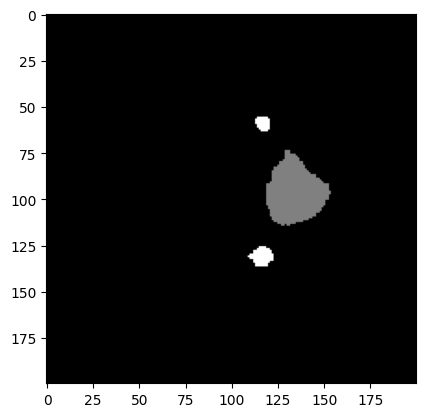

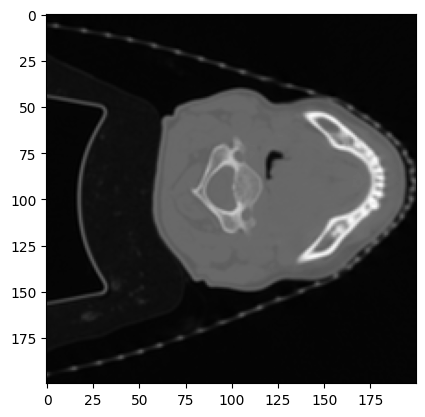

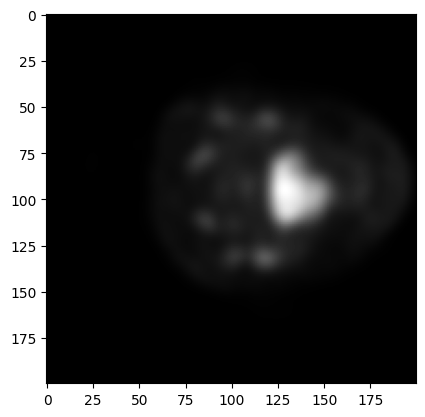

In [217]:
slice_num = 195
plt.imshow(gt_data1[:,:,slice_num], cmap='gray')
plt.show()
plt.imshow(ct_data1[:,:, slice_num], cmap='gray')
plt.show()
plt.imshow(pt_data1[:,:, slice_num], cmap='gray')
plt.show()

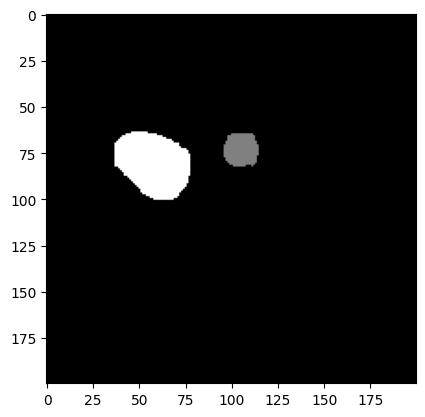

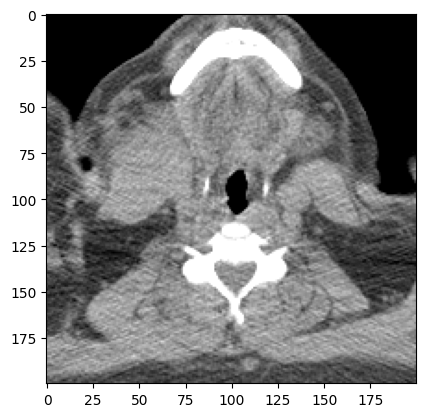

(torch.Size([1, 200, 200, 310]), torch.Size([1, 200, 200, 310]))

In [277]:
# Load and process the ground truth
gt_path = 'data/HMR-020/HMR-020_gt.nii.gz'
ct_path = 'data/HMR-020/HMR-020_ct.nii.gz'
pt_path = 'data/HMR-020/HMR-020_pt.nii.gz'
# gt_loader = LoadImage(ensure_channel_first=True)
# gt_data = gt_loader(gt_path)
# gt_data = Orientation(axcodes='RAS')(gt_data[0])

# Load and process the CT scan
# ct_loader = LoadImage(ensure_channel_first=True)
# ct_data = ct_loader(ct_path)
# ct_data = Orientation(axcodes='RAS')(ct_data[0])
# ct_data = torch.clip(ct_data, min=-1000, max=600)
# # apply train_transforms to ct_data
data = val_transforms({'ct': ct_path, 'seg': gt_path})
# data = train_transforms({'ct': ct_path, 'seg': gt_path})[0]

ct_data = data['ct']
gt_data = data['seg']

slice_num = 310-196
plt.imshow(gt_data[:,:,:,slice_num][0], cmap='gray')
plt.show()
plt.imshow(ct_data[:,:,:, slice_num][0], cmap='gray')
plt.show()
gt_data.shape, ct_data.shape

In [278]:
# Load the trained model
model_path = '/home/nada.saadi/MIS-FM/hecktor2022_cropped/ct_files/best_metric_unetr.pth'
model = SwinUNETR(
    img_size=(96, 96, 96),
    in_channels=1,
    out_channels=3,
    depths=(2, 2, 2, 2),
    num_heads=(3, 6, 12, 24),
    feature_size=24,
    norm_name="instance",
    drop_rate=0.0,
    attn_drop_rate=0.0,
    dropout_path_rate=0.0,
    normalize=True,
    use_checkpoint=False,
    spatial_dims=3,
    downsample="merging"
)
model.load_state_dict(torch.load(model_path))
model.eval()
model.cuda()

SwinUNETR(
  (swinViT): SwinTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv3d(1, 24, kernel_size=(2, 2, 2), stride=(2, 2, 2))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (layers1): ModuleList(
      (0): BasicLayer(
        (blocks): ModuleList(
          (0-1): 2 x SwinTransformerBlock(
            (norm1): LayerNorm((24,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              (qkv): Linear(in_features=24, out_features=72, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=24, out_features=24, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
              (softmax): Softmax(dim=-1)
            )
            (drop_path): Identity()
            (norm2): LayerNorm((24,), eps=1e-05, elementwise_affine=True)
            (mlp): MLPBlock(
              (linear1): Linear(in_features=24, out_features=96, bias=True)
              (linear2): Linear(in_features=

In [279]:
# Perform inference
with torch.no_grad():
    # prediction = model(ct_data.unsqueeze(0).cuda())
    # prediction = AsDiscrete(argmax=True, to_onehot=True, n_classes=3)(prediction)
    # prediction = prediction.cpu()
    prediction = sliding_window_inference(ct_data.unsqueeze(0).to(device), (96, 96, 96), 4, model)
    

In [165]:
gt_data.max(), ct_data.max(), prediction.max()

(metatensor(2.), metatensor(1.), metatensor(12.7549, device='cuda:0'))

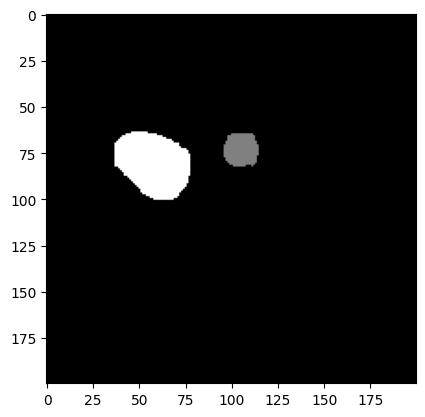

In [280]:
plt.imshow(gt_data[:,:,:,slice_num][0], cmap='gray')
plt.show()

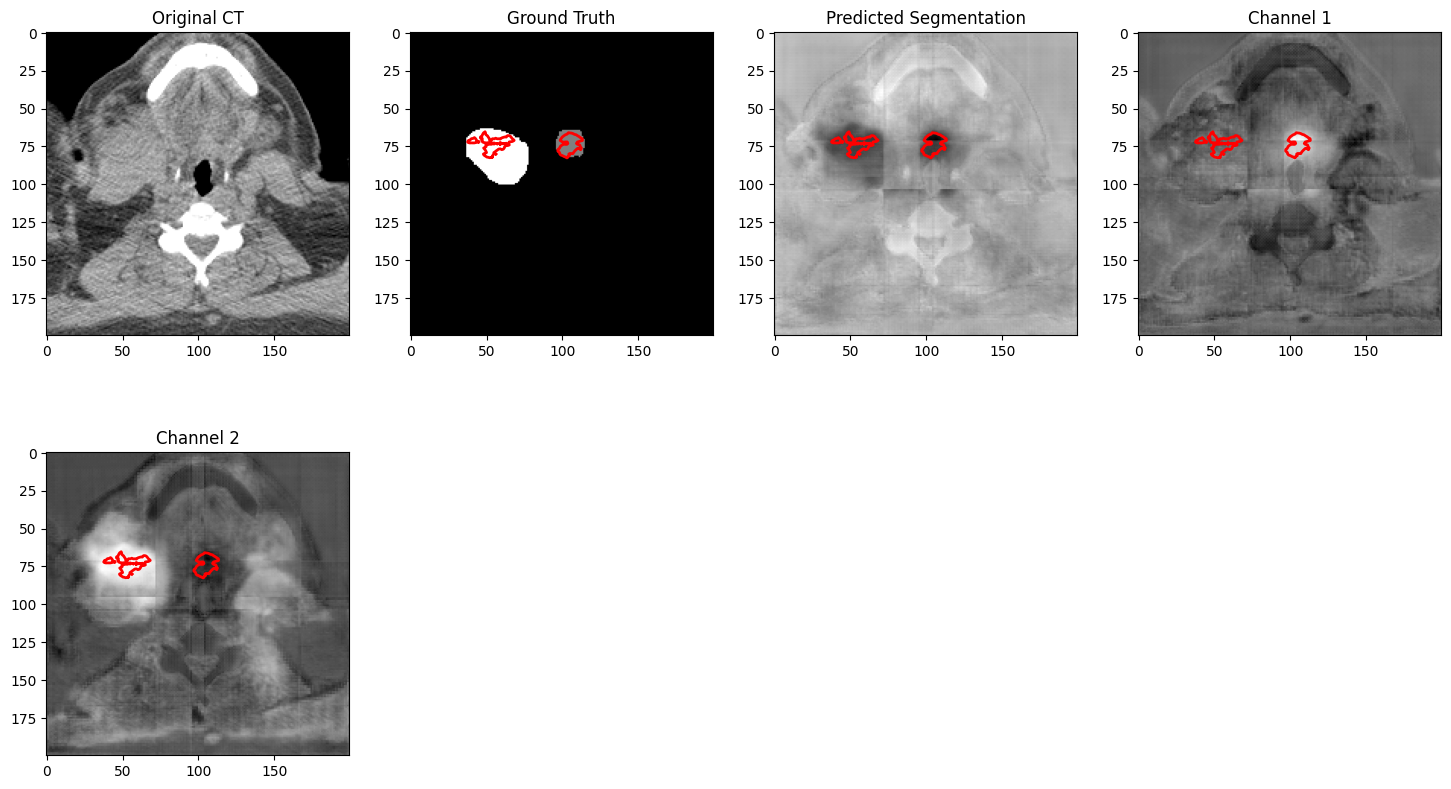

In [281]:
from skimage.measure import find_contours
import numpy as np
# transpose the prediction shape from 1x3x96x96x96 to 96x96x96x3
pred_img = prediction[0].permute(1, 2, 3, 0).cpu().numpy()
slice_num = 310 - 195

plt.figure("image", (18, 10))

# Rotate the ground truth and original image vertically
# gt = np.flipud(gt)
# ct_data = np.flipud(ct_data)

plt.subplot(2, 4, 1)
plt.imshow(ct_data[:,:,:,slice_num][0], cmap='gray')
plt.title("Original CT")

# Plot the contour of the predicted segmentation
contours = find_contours(pred_img[:,:,slice_num,0], 0.5)

plt.subplot(2, 4, 2)
# Plot the ground truth
plt.imshow(gt_data[:,:,:,slice_num][0], cmap='gray')
plt.title("Ground Truth")
for contour in contours:
    plt.plot(contour[:, 1], contour[:, 0], linewidth=2, color='red')

# Plot the predicted segmentation
plt.subplot(2, 4, 3)
plt.imshow(pred_img[:,:,slice_num,0], cmap='gray')
plt.title("Predicted Segmentation")
for contour in contours:
    plt.plot(contour[:, 1], contour[:, 0], linewidth=2, color='red')

# Plot the individual channels of the predicted segmentation
plt.subplot(2, 4, 4)
plt.imshow(pred_img[:,:,slice_num,1], cmap='gray')
plt.title("Channel 1")
for contour in contours:
    plt.plot(contour[:, 1], contour[:, 0], linewidth=2, color='red')
plt.subplot(2, 4, 5)
plt.imshow(pred_img[:,:,slice_num,2], cmap='gray')
plt.title("Channel 2")
for contour in contours:
    plt.plot(contour[:, 1], contour[:, 0], linewidth=2, color='red')
plt.show()


In [186]:
gt_data.shape, pred_img.shape

(torch.Size([1, 200, 200, 310]), (200, 200, 310, 3))

(-4.812091, 10.351175)

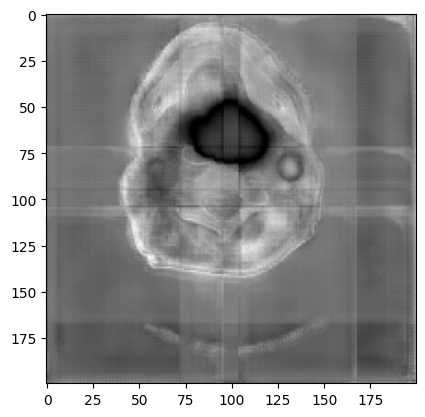

In [228]:
# lal_pred = np.zeros((pred_img.shape[0], pred_img.shape[1], pred_img.shape[2]))
lal_pred = np.clip(pred_img, 0, pred_img.max())
plt.imshow(np.sum(lal_pred, axis=3)[:,:,slice_num], cmap='gray')
plt.show()

In [282]:
# # transpose the prediction shape from 1x3x96x96x96 to 96x96x96x3
# pred_img = prediction[0].permute(1, 2, 3, 0).cpu().numpy()
# pred_img.shape
# plt.imshow(pred_img[:,:,48,0], cmap='gray')
# gt_img = gt_data.permute(1, 2, 3, 0).cpu().numpy()
# gt_img.shape

# plt.imshow(gt_img[:,:,32], cmap='gray')
# plt.show()
# plt.imshow(pred_img[:,:,48,1], cmap='gray')
# plt.show()
# plt.imshow(pred_img[:,:,48,2], cmap='gray')
plt.show() 

In [283]:
import pandas as pd

# Data to be summarized in the DataFrame
data = {
    "Metric": ["Tumor Dice", "Lymph Dice", "Average Dice"],
    "CT/PET": [0.69, 0.58, 0.65],
    "CT Only": [0.47, 0.53, 0.50]
}

# Creating the DataFrame
results_df = pd.DataFrame(data)

results_df



,Metric,CT/PET,CT Only
0,Tumor Dice,0.69,0.47
1,Lymph Dice,0.58,0.53
2,Average Dice,0.65,0.50


	Metric	CT/PET	CT Only
0	Tumor Dice	0.69	0.47
1	Lymph Dice	0.58	0.53
2	Average Dice	0.65	0.50

In [ ]:




# Specify slice number for visualization
slice_num = 150

# Find contours in the ground truth
contours = measure.find_contours(gt_data[:, slice_num, :], 0.5)[0]







# Visualization
plt.figure("image", (18, 10))

# Ground truth visualization
plt.subplot(2, 4, 1)
plt.imshow(gt_data[:, slice_num, :], cmap='gray')
plt.plot(contours[:, 1], contours[:, 0], linewidth=0.8, c='red', alpha=0.8)

# Original CT visualization
plt.subplot(2, 4, 2)
plt.imshow(ct_data[:, :, slice_num], cmap='gray')
plt.plot(contours[:, 1], contours[:, 0], linewidth=0.8, c='red', alpha=0.8)

# Model prediction visualization
plt.subplot(2, 4, 4)
plt.imshow(prediction[0, 1, :, :, slice_num], cmap='gray')
plt.plot(contours[:, 1], contours[:, 0], linewidth=0.8, c='red', alpha=0.8)

plt.show()


In [ ]:
check_path = "/home/nada.saadi/MIS-FM/hecktor2022_cropped/best_metric_swinmodel_s111_in176_DiceCE_AdamW_lr_1e-4_b4.pth"
output_dir = '/home/nada.saadi/MIS-FM/hecktor2022_cropped/APredictions-unetr'


In [ ]:
check_path = "/home/nada.saadi/MIS-FM/hecktor2022_cropped/best_metric_swinmodel_s111_in176_DiceCE_AdamW_lr_1e-4_b4.pth"
output_dir = '/home/nada.saadi/MIS-FM/hecktor2022_cropped/APredictions-unetr'

# Load the model
model = SwinUNETR(img_size=(96, 96, 96),
                  in_channels=2,
                  out_channels=3,
                  depths=(2, 2, 2, 2),
                  num_heads=(3, 6, 12, 24),
                  feature_size=24,
                  norm_name="instance",
                  drop_rate=0.0,
                  attn_drop_rate=0.0,
                  dropout_path_rate=0.0,
                  normalize=True,
                  use_checkpoint=False,
                  spatial_dims=3,
                  downsample="merging").to(device)

model.load_state_dict(torch.load(check_path))
model.eval()

# Rest of the code...
val_transforms = Compose([
    LoadImaged(keys=["ct", "pt", "seg"], ensure_channel_first=True),
    SpatialPadd(keys=["ct", "pt", "seg"], spatial_size=(200, 200, 310), method='end'),
    Orientationd(keys=["ct", "pt", "seg"], axcodes="PLS"),
    ClipCT(keys=["ct"]),
    MulPTFM(keys=["ct", "pt"]),
    ScaleIntensityd(keys=["ct"], minv=0, maxv=1),
    ConcatItemsd(keys=["pt", "ct"], name="ctpt"),
    NormalizeIntensityd(keys=["ctpt"], channel_wise=True),
    RandFlipd(
        keys=["ctpt"],
        spatial_axis=[2],
        prob=1,
    ),
])

files_ds = monai.data.Dataset(data=validation_files, transform=val_transforms)
print("Total validation cases:", len(files_ds))

val_loader = DataLoader(files_ds, batch_size=1, num_workers=4)

post_label = AsDiscrete(to_onehot=3)
post_pred = Compose([
    Invertd(
        keys="pred",
        transform=val_transforms,
        orig_keys="ctpt",
        nearest_interp=False,
        to_tensor=True,
    ),
])

dice_metric = DiceMetric(include_background=False, reduction="mean", get_not_nans=False)
dice_metric_batch = DiceMetric(include_background=False, reduction="mean_batch")

model = SegResNet(in_channels=2, out_channels=3, init_filters=16).to(device)

model.load_state_dict(torch.load(check_path))
model.eval()

with torch.no_grad():
    for i, batch in enumerate(val_loader):
        pat_id = batch['id'][0].split('/')[-1]
        roi_size = (96, 96, 96)
        sw_batch_size = 4
        val_inputs = (batch["ctpt"].cuda())
        sliding_window_inference(
            val_inputs, roi_size, sw_batch_size, overlap=0.25, predictor=model
        )

        val_outputs_list = decollate_batch(batch)
        val_output_convert = [
            post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list
        ]


        preds = torch.argmax(val_output_convert[0]['pred'] , dim=0)
        SaveImage(output_dir=output_dir, resample=False, separate_folder=False, output_postfix='seg')(preds),        
        val_inputs, roi_size, sw_batch_size, overlap=0.25, predictor=model,
        

        val_outputs_list = decollate_batch(batch)
        val_output_convert = [
            post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list
        ]

        preds = torch.argmax(val_output_convert[0]['pred'], dim=0)


#### The one below was wrong. Somehow

In [ ]:
metric_dictionary = {}
metric_dictionary['id'] = []
metric_dictionary['dice'] = []
metric_dictionary['dice_t'] = []
metric_dictionary['dice_n'] = []
pred_list = []
label_list = []

In [ ]:
val_transforms = Compose(
    [
        LoadImaged(keys=["ct", "pt", "seg"], ensure_channel_first = True),
        SpatialPadd(keys=["ct", "pt", "seg"], spatial_size=(200, 200, 310), method='end'),
        Orientationd(keys=["ct", "pt", "seg"], axcodes="PLS"),
        ClipCT(keys=["ct"]),
        MulPTFM(keys=["ct","pt"]),
        ScaleIntensityd(keys=["ct"], minv=0, maxv=1),
        #MulPTFM(keys=["ct","pt"]),
        ConcatItemsd(keys=["pt", "ct"], name="ctpt"),
        NormalizeIntensityd(keys=["ctpt"], channel_wise=True),
        RandFlipd(
            keys=["ctpt"],
            spatial_axis=[2],
            prob=1,
        ),
    ]
)
# val_transforms = Compose(
#     [
#         LoadImaged(keys=["ct", "pt",], ensure_channel_first = True),
#         ClipCT(keys=["ct", "pt"]),
#         MulPTFM(keys=["ct","pt"]),
#         ConcatItemsd(keys=["pt", "ct"], name="ctpt"),
#         Orientationd(keys=["ctpt"], axcodes="PLS"),
#         SpatialPadd(keys=["ctpt"], spatial_size=(176,176,176), method='end'),
#         NormalizeIntensityd(keys=["ctpt"], channel_wise=True),
#         RandFlipd(
#             keys=["ctpt"],
#             spatial_axis=[2],
#             prob=1,
#         ),
#     ]
# )

files_ds = monai.data.Dataset(data=validation_files, transform=val_transforms)
print("Total validation cases:", len(files_ds))

val_loader = DataLoader(files_ds, batch_size=1, num_workers=4)

output_dir = '/home/ikboljonsobirov/hecktor/fusion_vit/fusion_vit_project/inference/'

# post_label = AsDiscrete(to_onehot=3)
post_label = AsDiscrete(to_onehot=3)
post_pred = Compose([
    Invertd(
            keys="pred",  # invert the `pred` data field, also support multiple fields
            transform=val_transforms,
            orig_keys="ctpt",  # get the previously applied pre_transforms information on the `img` data field,
                              # then invert `pred` based on this information. we can use same info
                              # for multiple fields, also support different orig_keys for different fields
            nearest_interp=False,  # don't change the interpolation mode to "nearest" when inverting transforms
                                   # to ensure a smooth output, then execute `AsDiscreted` transform
            to_tensor=True,  # convert to PyTorch Tensor after inverting
        ),
    # AsDiscreted(keys="pred", argmax=True, to_onehot=3)
    ])

dice_metric = DiceMetric(include_background=False, reduction="mean", get_not_nans=False)
dice_metric_batch = DiceMetric(include_background=False, reduction="mean_batch")


model = SegResNet(in_channels=2, 
                  out_channels=3, 
                  init_filters=16).to(device)


model.load_state_dict(torch.load(check_path))
model.eval()
with torch.no_grad():
    for i, batch in enumerate(val_loader):

        pat_id = batch['id'][0].split('/')[-1]
        roi_size = (96, 96, 96)
        sw_batch_size = 4

        val_inputs, val_labels = (batch["ctpt"].cuda(), batch["seg"].cuda())
        
        batch["pred"] = sliding_window_inference(
            val_inputs, roi_size, sw_batch_size, overlap=0.25,  predictor=model
        )

        val_labels_list = decollate_batch(val_labels)
        val_labels_convert = [
                post_label(val_label_tensor) for val_label_tensor in val_labels_list
            ]

        val_outputs_list = decollate_batch(batch)
        val_output_convert = [
            post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list
        ]

        val_output_convert_pred = [pred['pred'] for pred in val_output_convert]

        dice_metric(y_pred=val_output_convert_pred, y=val_labels_convert)
        dice_metric_batch(y_pred=val_output_convert_pred, y=val_labels_convert)

        mean_dice_val = dice_metric.aggregate().item()
        metric_batch_val = dice_metric_batch.aggregate()

        metric_tumor = metric_batch_val[0].item()
        metric_lymph = metric_batch_val[1].item()

        dice_metric.reset()
        dice_metric_batch.reset()

        print("Processing: ", pat_id, " Dice: ", mean_dice_val)

        metric_dictionary['id'].append(pat_id)
        metric_dictionary['dice'].append(mean_dice_val)
        metric_dictionary['dice_t'].append(metric_tumor)
        metric_dictionary['dice_n'].append(metric_lymph)

        
        preds = torch.argmax(val_output_convert[0]['pred'] , dim=0)
        monai.transforms.SaveImage(output_dir=output_dir, resample=False, separate_folder=False, output_postfix='seg')(preds)

In [ ]:
np.mean(metric_dictionary['dice']), np.mean(metric_dictionary['dice_t']), np.mean(metric_dictionary['dice_n'])

In [ ]:
import torch
import numpy as np

In [ ]:
a = 709.0
b = -745.0

In [ ]:
a = np.float64(a)
b = np.float64(b)


In [ ]:
a = torch.tensor(a)
b = torch.tensor(b)

In [ ]:
torch.exp(a), torch.exp(b)